In [40]:
%reload_ext autoreload
%autoreload 1
import joblib
from ray import tune, train
import copy
import shap
import matplotlib.pyplot as plt
import polars as pl
import sys
import numpy as np
from sklearn.model_selection import train_test_split
import functions.transformers as tr
import functions.data_cleaning as dmf
import functions.plot_functions as pf
import functions.tuning as tunes
import functions.feature_engineering as feats
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from IPython.display import display,Markdown
import lightgbm as lgb
%aimport functions.tuning
%aimport functions.transformers
%aimport functions.data_cleaning
%aimport functions.plot_functions
%aimport functions.feature_engineering

In [2]:
BASE_FIG_SIZE=(8.5,4.5)
sns.set()

In [3]:
data_train=pl.read_parquet('data/data_full_train.parquet')
data_val=pl.read_parquet('data/data_full_val.parquet')

In [4]:
data_train=dmf.clean_accepted_rejected(data_train)
data_val=dmf.clean_accepted_rejected(data_val)

data_train=feats.date_features_accepted_rejected(data_train,"Application Date")
data_val=feats.date_features_accepted_rejected(data_val,"Application Date")

data_train=feats.title_text_features(data_train)
data_val=feats.title_text_features(data_val)

In [5]:
X_train = data_train.drop(columns=['Policy Code'])
X_val= data_val.drop(columns=['Policy Code'])
y_train = data_train['Policy Code']
y_val= data_val['Policy Code']

In [6]:
X_mini_train, discard1, y_mini_train, discard2 = train_test_split(
    X_train, y_train, stratify=y_train,train_size=3000000
)

X_mini_val, X_val, y_mini_val, y_val = train_test_split(
    X_val, y_val, stratify=y_val,train_size=900000
)

## Pipelines

### LightGBM

In [7]:
X_mini_train.null_count()

Amount Requested,Debt-To-Income Ratio,Zip Code,State,Employment Length,title,month_sin,month_cos,title_contains_numbers,title_length,title_starts_with_lowercase
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
204,171359,56,5,114794,6061,0,0,6061,6061,6061


#### Imputers

In [8]:
title_cat_imputer=tr.NotInImputerPolars(cat_no=12,fill_value=None)
zip_imputer=tr.NotInImputerPolars(cat_no=50,fill_value=None)
state_imputer=tr.NotInImputerPolars(cat_no=51,fill_value=None)
emp_length_imputer=tr.NotInImputerPolars(cat_no=12,fill_value=None)


imputer = tr.PolarsColumnTransformer(
    [
        tr.PolarsColumnTransformer.Step("title_imp",title_cat_imputer, "title"),
        tr.PolarsColumnTransformer.Step("zip_code_imp", zip_imputer, "Zip Code"),
        tr.PolarsColumnTransformer.Step("state_imp",state_imputer, "State"),
        tr.PolarsColumnTransformer.Step("len_imp",emp_length_imputer, "Employment Length"),
    ]
)

#### Encoders and selection

In [9]:
state_encoder = tr.TargetMeanOrderedLabeler()
zip_encoder = tr.TargetMeanOrderedLabeler()
title_encoder = tr.TargetMeanOrderedLabeler()
length_order = [
    None,
    "< 1 year",
    "1 year",
    "2 years",
    "3 years",
    "4 years",
    "5 years",
    "6 years",
    "7 years",
    "8 years",
    "9 years",
    "10+ years",
]

employment_encoder = tr.PolarsOrdinalEncoder(order=length_order)
encoder = tr.PolarsColumnTransformer(
    [
        tr.PolarsColumnTransformer.Step("state", state_encoder, "State"),
        tr.PolarsColumnTransformer.Step("zip_code",zip_encoder, "Zip Code"),
        tr.PolarsColumnTransformer.Step("title", title_encoder, "title"),
        tr.PolarsColumnTransformer.Step("emp_length", employment_encoder, "Employment Length"),
    ]
)
null_imp = tr.PolarsNullImputer(fill_value=-9)

model_lgbm = lgb.LGBMClassifier(
    class_weight="balanced",
    force_col_wise=True,
    verbose=-1,
    num_threads=1,
    random_state=1,
)

boruta = tr.BorutaFeatureSelectorPolars(model_lgbm, random_state=1, perc=100)

preprocess_lgbm = Pipeline(
    [
        ("imputer", imputer),
        ("encoder", encoder),
        ("null_imputer", null_imp),
        ("boruta", boruta),
    ]
)

#### Baseline for tunning

In [10]:
model_lgbm.fit(
    preprocess_lgbm.fit_transform(
        X_mini_train.sample(100000, seed=1), y_mini_train.sample(100000, seed=1)
    ),
    y_mini_train.sample(100000, seed=1),
)
baseline_preds=model_lgbm.predict(preprocess_lgbm.transform(X_mini_val.sample(30000,seed=1)))
print(f1_score(y_mini_val.sample(30000,seed=1),baseline_preds))

0.6669405642289783


In [11]:
full_pipeline = Pipeline(
    [
        ("preprocess", preprocess_lgbm),
        ("model", model_lgbm),
    ]
)

search_space_lgbm = {
    "preprocess__boruta__perc": tune.randint(1, 100),
    "preprocess__boruta__apply": tune.choice([True, False]),
    "model__num_leaves": tune.randint(10, 150),
    "model__n_estimators": tune.randint(1, 250),
    "model__learning_rate": tune.loguniform(0.001, 0.1),
    "model__bagging_freq": tune.randint(0, 10),
    "model__colsample_bytree": tune.uniform(0.2, 1.0),
    "model__subsample": tune.uniform(0.2, 1.0),
    "model__reg_alpha": tune.loguniform(0.001, 100),
    "model__reg_lambda": tune.loguniform(0.001, 100),
    "model__boosting_type": tune.choice(["gbdt", "dart", "rf"]),
    "model__class_weight": tune.choice(["balanced", None]),
    "model__max_bin": tune.randint(5, 200),
    "preprocess__encoder__step_params": {
        "state": {"how": tune.choice(["label", "mean"])},
        "zip_code": {"how": tune.choice(["label", "mean"])},
        "title": {"how": tune.choice(["label", "mean"])},
    },
}

models = tunes.Models()
models.add_model("lgbm_yn", full_pipeline, search_space_lgbm, metric_threshold=0.6)

### Tree

In [12]:
imputer_tree = copy.deepcopy(imputer)
encoder_tree = copy.deepcopy(encoder)
null_imp_tree = copy.deepcopy(null_imp)
preprocess_tree = Pipeline(
    [
        ("imputer", imputer_tree),
        ("encoder", encoder_tree),
        ("null_imputer", null_imp_tree),
    ]
)

model_tree = DecisionTreeClassifier()

full_pipeline_tree = Pipeline(
    [
        ("preprocess", preprocess_tree),
        ("model", model_tree),
    ]
)

search_space_tree = {
    "model__criterion": tune.choice(["gini", "entropy"]),
    "model__splitter": tune.choice(["best", "random"]),
    "model__max_depth": tune.randint(3, 50),
    "model__max_features": tune.choice(["sqrt", "log2", None]),
    "model__class_weight": tune.choice(["balanced", None]),
    "preprocess__encoder__step_params": {
        "state": {"how": tune.choice(["label", "mean"])},
        "zip_code": {"how": tune.choice(["label", "mean"])},
        "title": {"how": tune.choice(["label", "mean"])},
    },
}

models.add_model(
    "tree_yn", full_pipeline_tree, search_space_tree, metric_threshold=0.55
)

### Logreg

In [15]:
imputer_logreg = copy.deepcopy(imputer)
encoder_logreg = copy.deepcopy(encoder)
null_imp_logreg = tr.PolarsColumnTransformer(
    [
        tr.PolarsColumnTransformer.Step(
            "dti_imp", tr.PolarsNullImputer(10000), "Debt-To-Income Ratio"
        ),
        tr.PolarsColumnTransformer.Step(
            "requested_imp", tr.PolarsNullImputer(0), "Amount Requested"
        ),
        tr.PolarsColumnTransformer.Step(
            "contains_num_imp", tr.PolarsNullImputer(0), "title_contains_numbers"
        ),
        tr.PolarsColumnTransformer.Step(
            "lowercase_imp", tr.PolarsNullImputer(0), "title_starts_with_lowercase"
        ),
        tr.PolarsColumnTransformer.Step(
            "title_len_imp", tr.PolarsNullImputer(0), "title_length"
        ),
    ]
)

scaler=StandardScaler()

preprocess_logreg = Pipeline(
    [
        ("imputer", imputer_logreg),
        ("encoder", encoder_logreg),
        ("null_imputer", null_imp_logreg),
        ("scaler", scaler)
    ]
)

model_logreg = LogisticRegression(class_weight="balanced", max_iter=2000, tol=0.001)

full_pipeline_logreg = Pipeline(
    [
        ("preprocess", preprocess_logreg),
        ("model", model_logreg),
    ]
)

search_space_logreg = {
    "model__class_weight":tune.choice(['balanced',None]),
    "model__penalty": tune.choice(
        [
            "l1",
            "l2",
            None
        ]
    ),
    "model__C": tune.loguniform(0.001, 10.0),
    "model__solver": tune.choice(["saga"]),
    "preprocess__encoder__step_params": {
        "state": {"how": tune.choice(["label", "mean"])},
        "zip_code": {"how": tune.choice(["label", "mean"])},
        "title": {"how": tune.choice(["label", "mean"])},
    },
}

models.add_model(
    "logreg_yn",
    full_pipeline_logreg,
    search_space_logreg,
    metric_threshold=0.5,
    override_n=52,
)

In [18]:
models.tune_all(X_mini_train,y_mini_train,X_mini_val,y_mini_val,n=120,sample_size=300000)
joblib.dump(models, 'trained_models/tuned_models_yn.joblib')
# models=joblib.load('models_yn.joblib')


(Trainable pid=26012) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=26012)   warnings.warn(
(Trainable pid=26057) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=26057)   warnings.warn(


(Trainable pid=25873) Step 0 F-1 Score: 0.45233828748111443 [repeated 10x across cluster]
(Trainable pid=25916) Step 0 F-1 Score: 0.48487042131171276
(Trainable pid=26012) Step 0 F-1 Score: 0.48296913970889327


(Trainable pid=26012) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=26012)   warnings.warn(


(Trainable pid=25961) Step 0 F-1 Score: 0.48469498516535203


(Trainable pid=26331) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=26331)   warnings.warn(


(Trainable pid=25873) Step 1 F-1 Score: 0.45280612244897955


(Trainable pid=26057) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=26057)   warnings.warn(


(Trainable pid=26102) Step 0 F-1 Score: 0.48392701998262383 [repeated 3x across cluster]
(Trainable pid=26240) Step 0 F-1 Score: 0.4907016060862215 [repeated 2x across cluster]
(Trainable pid=25916) Step 1 F-1 Score: 0.4768084949487501
(Trainable pid=26012) Step 1 F-1 Score: 0.4898532033531844


(Trainable pid=26012) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=26012)   warnings.warn(


(Trainable pid=26331) Step 0 F-1 Score: 0.45232067510548524


(Trainable pid=26331) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=26331)   warnings.warn(


(Trainable pid=26286) Step 0 F-1 Score: 0.4937385676093992
(Trainable pid=25873) Step 2 F-1 Score: 0.4546612868974304 [repeated 2x across cluster]
(Trainable pid=26193) Step 1 F-1 Score: 0.45224351028792015 [repeated 3x across cluster]
(Trainable pid=26057) Step 1 F-1 Score: 0.47737656595431105


(Trainable pid=26057) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=26057)   warnings.warn(


(Trainable pid=25916) Step 2 F-1 Score: 0.48608480256447617
(Trainable pid=26147) Step 2 F-1 Score: 0.48932626797880396 [repeated 3x across cluster]


(Trainable pid=26545) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=26545)   warnings.warn(


(Trainable pid=26331) Step 1 F-1 Score: 0.4526711067025649 [repeated 2x across cluster]


(Trainable pid=26331) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=26331)   warnings.warn(


(Trainable pid=25961) Step 2 F-1 Score: 0.48630536130536134 [repeated 3x across cluster]


(Trainable pid=26697) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=26697)   warnings.warn(


(Trainable pid=26286) Step 1 F-1 Score: 0.48769000214086916 [repeated 2x across cluster]


(Trainable pid=26798) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=26798)   warnings.warn(


(Trainable pid=26468) Step 0 F-1 Score: 0.492996410220314 [repeated 2x across cluster]
(Trainable pid=26102) Step 2 F-1 Score: 0.4864116575591986
(Trainable pid=26378) Step 2 F-1 Score: 0.4538575772576197


(Trainable pid=26950) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=26950)   warnings.warn(


(Trainable pid=26622) Step 0 F-1 Score: 0.4896002256222239
(Trainable pid=26331) Step 2 F-1 Score: 0.45408885116015846
(Trainable pid=26545) Step 0 F-1 Score: 0.48392701998262383


(Trainable pid=26545) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=26545)   warnings.warn(


(Trainable pid=26286) Step 2 F-1 Score: 0.496094304786252


(Trainable pid=27041) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=27041)   warnings.warn(


(Trainable pid=26697) Step 0 F-1 Score: 0.4829744430370316
(Trainable pid=26468) Step 1 F-1 Score: 0.48742857142857143
(Trainable pid=26898) Step 0 F-1 Score: 0.45015964352127996 [repeated 2x across cluster]


(Trainable pid=26798) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 2x across cluster]
(Trainable pid=26798)   warnings.warn( [repeated 2x across cluster]


(Trainable pid=27087) Step 0 F-1 Score: 0.4848399180154075 [repeated 2x across cluster]
(Trainable pid=26847) Step 0 F-1 Score: 0.4937750580291201
(Trainable pid=26622) Step 1 F-1 Score: 0.4854673998428907
(Trainable pid=26995) Step 1 F-1 Score: 0.48012035246077794 [repeated 2x across cluster]
(Trainable pid=26468) Step 2 F-1 Score: 0.49570220927754494 [repeated 2x across cluster]


(Trainable pid=26950) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=26950)   warnings.warn(


(Trainable pid=27135) Step 1 F-1 Score: 0.47626570915619393 [repeated 2x across cluster]


(Trainable pid=26697) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=26697)   warnings.warn(


(Trainable pid=26545) Step 1 F-1 Score: 0.47703310477033106 [repeated 5x across cluster]
(Trainable pid=27135) Step 2 F-1 Score: 0.48594923131927076
(Trainable pid=27041) Step 0 F-1 Score: 0.49346083532555196


(Trainable pid=27041) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 2x across cluster]
(Trainable pid=27041)   warnings.warn( [repeated 2x across cluster]


(Trainable pid=27221) Step 0 F-1 Score: 0.4847670884286422 [repeated 2x across cluster]
(Trainable pid=26798) Step 1 F-1 Score: 0.47703310477033106


(Trainable pid=26798) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=26798)   warnings.warn(


(Trainable pid=27221) Step 1 F-1 Score: 0.47626570915619393
(Trainable pid=26847) Step 1 F-1 Score: 0.48747412747127256 [repeated 2x across cluster]
(Trainable pid=27221) Step 2 F-1 Score: 0.48580622095101894
(Trainable pid=26545) Step 2 F-1 Score: 0.486451048951049
(Trainable pid=26950) Step 1 F-1 Score: 0.4879440719075474 [repeated 2x across cluster]


(Trainable pid=26950) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=26950)   warnings.warn(


(Trainable pid=27321) Step 0 F-1 Score: 0.49278423090461104
(Trainable pid=27041) Step 1 F-1 Score: 0.4880068532267276


(Trainable pid=27041) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=27041)   warnings.warn(


(Trainable pid=26798) Step 2 F-1 Score: 0.486451048951049 [repeated 2x across cluster]
(Trainable pid=27418) Step 0 F-1 Score: 0.4929617117117118
(Trainable pid=26847) Step 2 F-1 Score: 0.4965566205182819
(Trainable pid=27546) Step 0 F-1 Score: 0.49278423090461104 [repeated 2x across cluster]
(Trainable pid=27624) Step 0 F-1 Score: 0.4930677739460905 [repeated 2x across cluster]
(Trainable pid=27721) Step 0 F-1 Score: 0.49274954244685354
(Trainable pid=27321) Step 1 F-1 Score: 0.48742857142857143
(Trainable pid=27775) Step 0 F-1 Score: 0.4930677739460905 [repeated 2x across cluster]


(Trainable pid=28090) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=28090)   warnings.warn(


(Trainable pid=27418) Step 1 F-1 Score: 0.48742857142857143 [repeated 2x across cluster]
(Trainable pid=27321) Step 2 F-1 Score: 0.49577264653641206 [repeated 3x across cluster]
(Trainable pid=27932) Step 0 F-1 Score: 0.4926781188397635
(Trainable pid=27546) Step 1 F-1 Score: 0.48742857142857143


(Trainable pid=28173) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=28173)   warnings.warn(


(Trainable pid=27370) Step 2 F-1 Score: 0.49570220927754494
(Trainable pid=27624) Step 1 F-1 Score: 0.48742857142857143


(Trainable pid=28250) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=28250)   warnings.warn(


(Trainable pid=27418) Step 2 F-1 Score: 0.49570220927754494 [repeated 2x across cluster]
(Trainable pid=27775) Step 1 F-1 Score: 0.4876829703677258 [repeated 3x across cluster]


(Trainable pid=28328) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=28328)   warnings.warn(
(Trainable pid=28370) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=28370)   warnings.warn(


(Trainable pid=28090) Step 0 F-1 Score: 0.4937750580291201 [repeated 2x across cluster]
(Trainable pid=27855) Step 1 F-1 Score: 0.4876097979004499


(Trainable pid=28451) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 2x across cluster]
(Trainable pid=28451)   warnings.warn( [repeated 2x across cluster]


(Trainable pid=27721) Step 2 F-1 Score: 0.49570220927754494
(Trainable pid=27932) Step 1 F-1 Score: 0.48742857142857143 [repeated 2x across cluster]


(Trainable pid=28530) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=28530)   warnings.warn(


(Trainable pid=27775) Step 2 F-1 Score: 0.4957386363636364


(Trainable pid=28583) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=28583)   warnings.warn(


(Trainable pid=28173) Step 0 F-1 Score: 0.49346083532555196


(Trainable pid=28173) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=28173)   warnings.warn(
(Trainable pid=28660) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=28660)   warnings.warn(


(Trainable pid=27855) Step 2 F-1 Score: 0.4957738475744016
(Trainable pid=28250) Step 0 F-1 Score: 0.49346083532555196


(Trainable pid=28250) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=28250)   warnings.warn(
(Trainable pid=28739) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=28739)   warnings.warn(


(Trainable pid=28012) Step 1 F-1 Score: 0.4875089221984296 [repeated 2x across cluster]
(Trainable pid=28328) Step 0 F-1 Score: 0.49346083532555196


(Trainable pid=28328) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=28328)   warnings.warn(
(Trainable pid=28818) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=28818)   warnings.warn(


(Trainable pid=28370) Step 0 F-1 Score: 0.49346083532555196


(Trainable pid=28370) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=28370)   warnings.warn(
(Trainable pid=28090) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=28090)   warnings.warn(


(Trainable pid=28451) Step 0 F-1 Score: 0.49346083532555196 [repeated 2x across cluster]


(Trainable pid=28451) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=28451)   warnings.warn(


(Trainable pid=28530) Step 0 F-1 Score: 0.49346083532555196


(Trainable pid=28530) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=28530)   warnings.warn(


(Trainable pid=28012) Step 2 F-1 Score: 0.4965566205182819


(Trainable pid=28583) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=28583)   warnings.warn(


(Trainable pid=28173) Step 1 F-1 Score: 0.4880068532267276 [repeated 2x across cluster]


(Trainable pid=28173) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=28173)   warnings.warn(
(Trainable pid=28902) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 2x across cluster]
(Trainable pid=28902)   warnings.warn( [repeated 2x across cluster]


(Trainable pid=28250) Step 1 F-1 Score: 0.4880068532267276 [repeated 2x across cluster]


(Trainable pid=28250) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=28250)   warnings.warn(


(Trainable pid=28739) Step 0 F-1 Score: 0.49346083532555196
(Trainable pid=28090) Step 2 F-1 Score: 0.4965566205182819


(Trainable pid=28739) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=28739)   warnings.warn(


(Trainable pid=28328) Step 1 F-1 Score: 0.4880068532267276


(Trainable pid=28328) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=28328)   warnings.warn(


(Trainable pid=28818) Step 0 F-1 Score: 0.49346083532555196


(Trainable pid=28818) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=28818)   warnings.warn(


(Trainable pid=28370) Step 1 F-1 Score: 0.4880068532267276


(Trainable pid=28370) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 2x across cluster]
(Trainable pid=28370)   warnings.warn( [repeated 2x across cluster]


(Trainable pid=28451) Step 1 F-1 Score: 0.4880068532267276


(Trainable pid=28451) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=28451)   warnings.warn(


(Trainable pid=28530) Step 1 F-1 Score: 0.4880068532267276 [repeated 2x across cluster]


(Trainable pid=28530) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=28530)   warnings.warn(


(Trainable pid=28583) Step 1 F-1 Score: 0.4880068532267276 [repeated 2x across cluster]


(Trainable pid=28583) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 2x across cluster]
(Trainable pid=28583)   warnings.warn( [repeated 2x across cluster]


(Trainable pid=28328) Step 2 F-1 Score: 0.4962384669978708
(Trainable pid=28660) Step 1 F-1 Score: 0.4880068532267276


(Trainable pid=28660) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 2x across cluster]
(Trainable pid=28660)   warnings.warn( [repeated 2x across cluster]
(Trainable pid=29216) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 2x across cluster]
(Trainable pid=29216)   warnings.warn( [repeated 2x across cluster]


(Trainable pid=28370) Step 2 F-1 Score: 0.4962384669978708 [repeated 2x across cluster]
(Trainable pid=28451) Step 2 F-1 Score: 0.4962384669978708 [repeated 2x across cluster]


(Trainable pid=28818) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 2x across cluster]
(Trainable pid=28818)   warnings.warn( [repeated 2x across cluster]


(Trainable pid=28530) Step 2 F-1 Score: 0.4962384669978708 [repeated 3x across cluster]
(Trainable pid=28583) Step 2 F-1 Score: 0.4962384669978708
(Trainable pid=28660) Step 2 F-1 Score: 0.4962384669978708
(Trainable pid=29061) Step 0 F-1 Score: 0.4937750580291201


(Trainable pid=29061) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters [repeated 2x across cluster]
(Trainable pid=29061)   warnings.warn( [repeated 2x across cluster]


(Trainable pid=28739) Step 2 F-1 Score: 0.4962384669978708


(Trainable pid=29137) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=29137)   warnings.warn(


(Trainable pid=28818) Step 2 F-1 Score: 0.4962384669978708 [repeated 2x across cluster]


(Trainable pid=28902) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=28902)   warnings.warn(


(Trainable pid=29216) Step 0 F-1 Score: 0.48469498516535203 [repeated 2x across cluster]


(Trainable pid=29216) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=29216)   warnings.warn(


(Trainable pid=28983) Step 1 F-1 Score: 0.4880068532267276


(Trainable pid=28983) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=28983)   warnings.warn(


(Trainable pid=28902) Step 2 F-1 Score: 0.4962384669978708
(Trainable pid=29061) Step 1 F-1 Score: 0.48747412747127256


(Trainable pid=29061) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=29061)   warnings.warn(


(Trainable pid=29137) Step 1 F-1 Score: 0.48747412747127256


(Trainable pid=29137) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=29137)   warnings.warn(


(Trainable pid=29216) Step 1 F-1 Score: 0.4771102100995208 [repeated 2x across cluster]


(Trainable pid=29216) /home/gediminas/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
(Trainable pid=29216)   warnings.warn(


(Trainable pid=29061) Step 2 F-1 Score: 0.4965566205182819
(Trainable pid=29137) Step 2 F-1 Score: 0.4965566205182819
(Trainable pid=29216) Step 2 F-1 Score: 0.48656520789339547


2023-10-12 06:12:11,371	INFO tune.py:1143 -- Total run time: 973.19 seconds (973.03 seconds for the tuning loop).


logreg_yn tuned.


['trained_models/tuned_models_yn.joblib']

##### Features dropped by Boruta:

In [35]:
selected_features = (
    models.models["lgbm_yn"]
    .pipeline["preprocess"]
    .fit_transform(
        X_mini_train, y_mini_train
    )
    .columns
)
features_to_drop = [
    feature for feature in X_mini_train.columns if feature not in selected_features
]
features_to_drop

[]

##### Dropping features manually instead of Boruta algorithm:

In [36]:
models.models["lgbm_yn"].pipeline["preprocess"].steps.pop(-1)
models.models["lgbm_yn"].pipeline["preprocess"].steps.append(
    ("feature_remover", tr.FeatureRemover(feats_to_drop=features_to_drop))
)

In [37]:
models.models['lgbm_yn'].pipeline.fit(X_train,y_train)
models.models['logreg_yn'].pipeline.fit(X_train,y_train)
models.models['tree_yn'].pipeline.fit(X_train,y_train)


Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('imputer',
                                  PolarsColumnTransformer(steps=OrderedDict([('title_imp',
                                                                              <functions.transformers.PolarsColumnTransformer.Step object at 0x7f1df0ae1490>),
                                                                             ('zip_code_imp',
                                                                              <functions.transformers.PolarsColumnTransformer.Step object at 0x7f1d7c1ca370>),
                                                                             ('state_imp',
                                                                              <functions.transformers.PolarsColumnTransformer.Step ob...
                 LGBMClassifier(bagging_freq=1, boosting_type='rf',
                                colsample_bytree=0.6493512125583797,
                                force_col_wise=True,
                                learning_rate=0.0016953844895474985, max_bin=88,
                                n_estimators=163, num_leaves=64, num_threads=1,
                                random_state=RandomState(MT19937) at 0x7F1DD8D66840,
                                reg_alpha=0.2593993722718682,
                                reg_lambda=0.0065935503244421035,
                                subsample=0.5824004652925907, verbose=-1))])

In [31]:
# joblib.dump(models,'trained_models/trained_models_yn')

['trained_models/trained_models_yn']

In [23]:
models.models['lgbm_yn'].best_params

{'preprocess__boruta__perc': 23,
 'preprocess__boruta__apply': True,
 'model__num_leaves': 64,
 'model__n_estimators': 163,
 'model__learning_rate': 0.0016953844895474985,
 'model__bagging_freq': 1,
 'model__colsample_bytree': 0.6493512125583797,
 'model__subsample': 0.5824004652925907,
 'model__reg_alpha': 0.2593993722718682,
 'model__reg_lambda': 0.0065935503244421035,
 'model__boosting_type': 'rf',
 'model__class_weight': None,
 'model__max_bin': 88,
 'preprocess__encoder__step_params': {'state': {'how': 'mean'},
  'zip_code': {'how': 'label'},
  'title': {'how': 'label'}}}

In [24]:
models.models['tree_yn'].best_params

{'model__criterion': 'gini',
 'model__splitter': 'best',
 'model__max_depth': 9,
 'model__max_features': None,
 'model__class_weight': None,
 'preprocess__encoder__step_params': {'state': {'how': 'label'},
  'zip_code': {'how': 'label'},
  'title': {'how': 'mean'}}}

In [25]:
models.models['logreg_yn'].best_params

{'model__class_weight': None,
 'model__penalty': None,
 'model__C': 0.011850174592261594,
 'model__solver': 'saga',
 'preprocess__encoder__step_params': {'state': {'how': 'mean'},
  'zip_code': {'how': 'mean'},
  'title': {'how': 'mean'}}}

In [26]:
preds_lgbm =models.models['lgbm_yn'].pipeline.predict(X_val)
preds_logreg =models.models['logreg_yn'].pipeline.predict(X_val)
preds_tree =models.models['tree_yn'].pipeline.predict(X_val)
# 

In [27]:
print(classification_report(y_val,preds_lgbm))
print(classification_report(y_val,preds_logreg))
print(classification_report(y_val,preds_tree))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97   4625361
           1       0.66      0.80      0.73    449854

    accuracy                           0.95   5075215
   macro avg       0.82      0.88      0.85   5075215
weighted avg       0.95      0.95      0.95   5075215

              precision    recall  f1-score   support

           0       0.94      0.98      0.96   4625361
           1       0.66      0.39      0.49    449854

    accuracy                           0.93   5075215
   macro avg       0.80      0.69      0.73   5075215
weighted avg       0.92      0.93      0.92   5075215

              precision    recall  f1-score   support

           0       0.97      0.97      0.97   4625361
           1       0.70      0.72      0.71    449854

    accuracy                           0.95   5075215
   macro avg       0.83      0.85      0.84   5075215
weighted avg       0.95      0.95      0.95   5075215



In [51]:
preds_proba_lgbm=models.models['lgbm_yn'].pipeline.predict_proba(X_val)

In [54]:
preds_proba_tree=models.models['tree_yn'].pipeline.predict_proba(X_val)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='False Positive Rate', ylabel='True Positive Rate'>)

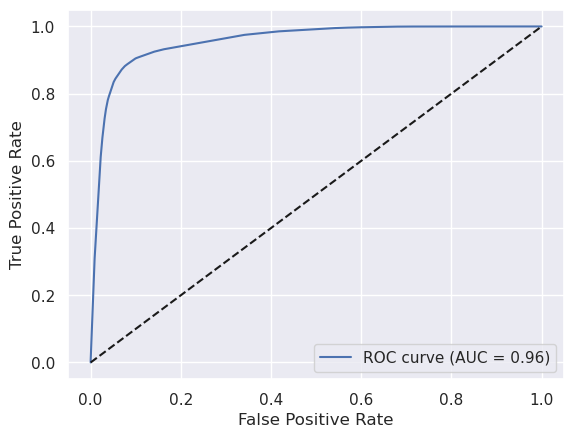

In [56]:
pf.plot_roc_curve(y_val,preds_proba_tree[:,1])

In [28]:
best_pipeline=models.models['lgbm_yn'].pipeline

 97%|=================== | 9691/10000 [00:32<00:01]       No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


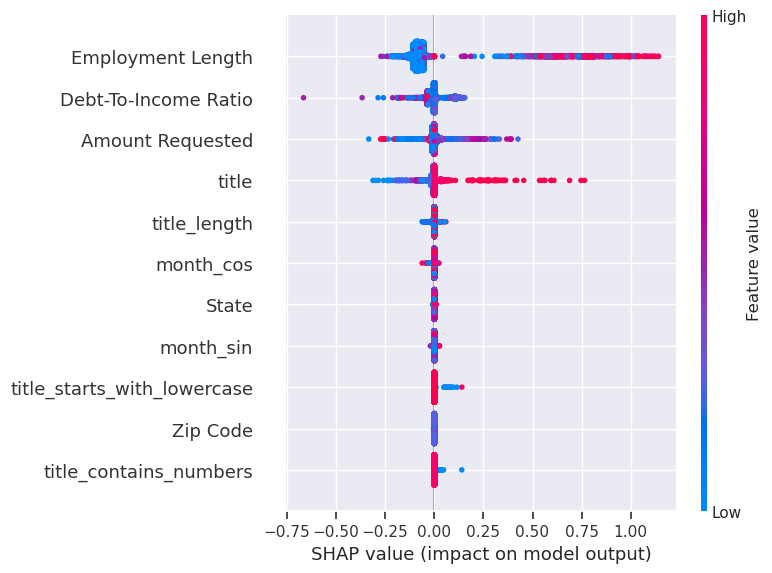

In [29]:
names = best_pipeline["preprocess"].transform(X_mini_val.sample(1000, seed=1)).columns
explainer_tree = shap.TreeExplainer(
    best_pipeline["model"],
    data=best_pipeline["preprocess"]
    .transform((X_mini_val.sample(10000, seed=1)))
    .to_numpy(),
    model_output="probability",
)

shap_values = explainer_tree.shap_values(
    best_pipeline["preprocess"].transform(X_mini_val.sample(10000, seed=1)).to_numpy()
)

shap.summary_plot(
    shap_values,
    best_pipeline["preprocess"].transform(X_mini_val.sample(10000, seed=1)).to_numpy(),
    feature_names=names,
    max_display=20,
)

In [30]:
best_pipeline.fit(X_train.vstack(X_val), pl.concat([y_train,y_val]))

KeyboardInterrupt: 

In [ ]:
data_test=pl.read_parquet('data/data_full_test.parquet')

In [ ]:
data_test=dmf.clean_accepted_rejected(data_test)
data_test=feats.date_features_accepted_rejected(data_test,"Application Date")
data_test=feats.title_text_features(data_test)

X_test = data_test.drop(columns=["Policy Code"])
y_test = data_test["Policy Code"]

In [ ]:
final_preds = best_pipeline.predict(X_test)
print(classification_report(data_test["Policy Code"], final_preds))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98   6647748
           1       0.64      0.73      0.68    346669

    accuracy                           0.97   6994417
   macro avg       0.81      0.86      0.83   6994417
weighted avg       0.97      0.97      0.97   6994417



In [ ]:
# best_pipeline.fit(X_train.vstack(X_val).vstack(X_test), pl.concat([y_train,y_val,y_test]))
joblib.dump(best_pipeline,"trained_models/final_model_accepted_rejected.joblib")

['trained_models/final_model_accepted_rejected.joblib']